# Homework Solution 4

Ming Hong (mh4286@nyu.edu)

In [22]:
%pylab inline 
import pandas as pd
import inst, fmt, trid, time
import numpy as np
import sympy as sp
import scipy.optimize as opt

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## Problem 1: 

Implement the Thomas algorithm for solving tri-diagonal linear systems:

Do your own reading and research on <a href=http://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm>Thomas algorithm</a>  and implement and test it in python.

### Solution

In [2]:
def thomas(M,y):
    '''Thomas algorithm to solve for tridiagonal linear system Mx=y'''
    length = len(M)
    b = np.diag(M)
    a = np.diag(M[1:,:-1])
    c = np.diag(M[:-1,1:])
    
    N = M - np.diag(b) # checker matrix 
    N[1:,:-1] = N[1:,:-1] - np.diag(a)
    N[:-1,1:] = N[:-1,1:] - np.diag(c)
    if M.shape[0] != M.shape[1] or not np.all(N==0):
        raise ValueError('matrix is not tridiagonal')
    
    a = np.insert(a,0,0)
    c = np.append(c,0) 
    x = np.zeros(length)
    cp = np.zeros(length)
    yp = np.zeros(length)
    
    cp[0] = c[0]/b[0]
    yp[0] = y[0]/b[0]
    
    for i,m in enumerate(M):
        if i > 0 & i < length-1:
            cp[i] = c[i] / (b[i] - a[i]*cp[i-1])
            yp[i] = (y[i] - a[i]*yp[i-1])/(b[i] - a[i]*cp[i-1])
        elif i == length - 1:
            yp[i] = (y[i] - a[i]*yp[i-1])/(b[i] - a[i]*cp[i-1])
    
    k = np.arange(length-1)[::-1]
    x[length-1] = yp[length-1]
    
    for i in k:
        x[i] = yp[i] - cp[i]*x[i+1]
    
    return x

x0 = np.array([.1, 1.,2, 3., 5., 10., 25.])
y0 = np.array([.0025, .01, .016,.02, .025, .030, .035])
ts = trid.TridiagTension(1.)
ts.build(x0,y0) # form a tridiagonal system

M = ts.a
y = ts.b
x = thomas(M,y)

x_b = np.linalg.solve(M,y) # built-in solver

X1,X2 = sp.symbols("x_Thomas x_built-in")

fmt.displayMath(fmt.joinMath('=', X1, sp.Matrix(x).evalf(3)))
fmt.displayMath(fmt.joinMath('=', X2, sp.Matrix(x_b).evalf(3)))

print("Same answers? %s" % np.allclose(x,x_b))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Same answers? True


All close? True


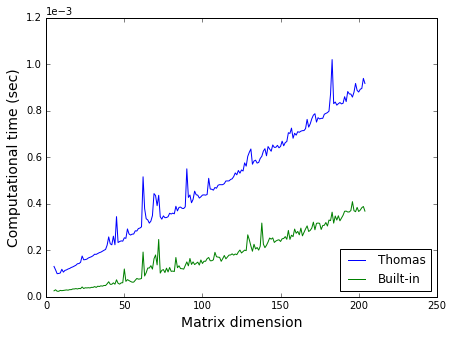

In [21]:
# validate that the algorithm is linear
t = np.zeros(200)
tt = np.zeros(200)
check = np.zeros(200)
for i in range(5,205,1):
    x0 = np.arange(0.1,(i+1)*0.1,0.1)
    y0 = np.log(x0+1)
    
    ts = trid.TridiagTension(1)
    ts.build(x0,y0)
    M = ts.a
    y = ts.b

    t1 = time.clock()
    ans1 = thomas(M,y)
    t2 = time.clock()
    t[i-5] = t2 - t1
    
    # built-in solver
    t3 = time.clock()
    ans2 = np.linalg.solve(M,y)
    t4 = time.clock()
    tt[i-5] = t4 - t3
    
    if np.allclose(ans1,ans2):
        check[i-5] = 1

print("All close? %s" % np.allclose(np.sum(check),200))
plt.figure(figsize=(7,5))
plt.plot(range(5,205,1),t, label='Thomas')
plt.plot(range(5,205,1),tt, label='Built-in')
plt.xlabel('Matrix dimension',fontsize=14)
plt.ylabel('Computational time (sec)',fontsize=14)
plt.legend(loc='lower right')
plt.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
plt.show() 

## Problem 2

Given the following benchmark swap quotes for USD, suppose all swap coupons are paid semi-annually:

In [4]:
terms = np.array([1, 2, 3, 5, 7, 10, 12, 15, 20, 25])*1.
par = np.array([.042, .043, .047, .054, .057, .06, .061, .059, .056, .0555])

df_swap = pd.DataFrame(np.array([par]).T*100, columns=["Par Spread (%)"], 
                       index=map(lambda m: '%dY' % m, terms))
fmt.displayDF(df_swap.T, 2, 2)

,1Y,2Y,3Y,5Y,7Y,10Y,12Y,15Y,20Y,25Y
Par Spread (%),4.2,4.3,4.7,5.4,5.7,6.0,6.1,5.9,5.6,5.5


The swap pricers are provided by the python class ```Swap``` and the pricing function ```priceSwap```, both are defined in <a href=https://raw.githubusercontent.com/yadongli/nyumath2048/master/lib/swap.py>swap.py</a> under the folder nyumath2048/lib of the github repository.

Note the following assumptions of the swap pricer provided:
* it prices a receiver swap, you need to flip the sign to price a payer swap
* it ignores important details, such as day count conventions, do not use this code to trade!

The following are some sample codes of how to use the swap pricers:

In [5]:
from swap import Swap, priceSwap
import lin

# the pricing function if curve(t) is the cumulative yield, ie, -log(b(t)) (this is like return)
def y2pv(swap, curve) :
    discf = lambda ts: np.exp(-curve(ts))
    return priceSwap(swap, discf)

# create the benchmark instruments
bm_swaps = {Swap(m, c, 2) : 0 for m, c in zip (terms, par)}

# price a single swap with a straight curve in y(t)
flat = lin.RationalTension(lbd = 5.)
flat.build(terms, terms*.04) # create a dummy curve of flat 0.04 rate

pvs = {swap.maturity : y2pv(swap, flat) for swap in bm_swaps.keys()}
print "PV by maturity"
print "\n".join(["%.2g Y : %.4g" % (m, v) for m, v in pvs.items()])

PV by maturity
1 Y : 0.00155
2 Y : 0.004943
3 Y : 0.01846
5 Y : 0.06101
7 Y : 0.1003
10 Y : 0.1599
12 Y : 0.1943
15 Y : 0.2077
20 Y : 0.2126
25 Y : 0.2362


1. Explain what is the purpose of the +1e-6 in the first line of the priceSwap function
2. Use the market data above to boostrap the IR curve by interpolating the cumulative yield $y(t) = -\log(b(t))$ with tension spline, where $b(t)$ is the discount factor (i.e., the price of risk free zero coupon bonds). After bootstraping the curve, re-price the benchmark instruments using the bootstrapped curve, and compute the L-2 norm of the absolute pricing errors. Show how the pricing error of the bootstraped curve depend on the tension parameter $\lambda$.
3. Using the iteration technique to reduce the L-2 norm of the error below 1bps, how many iteration is needed for the error to go below 1bps?
4. From the curve built in the previous step, compute both the $y(t)$ and the instantaneous forward rate $f(t) = -\frac{1}{b(t)}\frac{d b(t)}{d t} = \frac{d y(t)}{dt}$, and show how their shapes change with the tension parameter $\lambda$. In addition, compare the changes in the instantaneous forward rates with 1bps change in the 5Y par swap rate. You can use the deriv() method in the Tension spline class. 
6. Repeat the previous step, but directly interpolating the forward rates $f(t)$, and comment on whether it is suitable in practice.
5. [extra credit] Build the curve by interpolating the zero rate with tension spline instead, i.e, $r(t) = \frac{y(t)}{t}$, compare how the forward rates shape and perturbations differ from those obtained in step 4, and comment on the pro and cons between interpolating $r(t)$ and $y(t)$.
7. [extra credit] write your own bootstrap function instead of calling those provided by the class library

Hint: 
* write your code in a modular and reusable way; you can re-use the code provided as part of the class lecture, but you get extra credit if you can write your own bootstraping. The source code of the inst package is hidden from you, but you can figure out how to use them by reading their docstring with help(), please use the python codes in the lecture slides as examples.
* be careful with the choice of boundary for the root search, allow negative rates often helps stablizing the bootstraping, even though it does not make economic sense
* in step 5, you may have to mix the old and new results to stablize the iteration, (e.g., use mixf=0.5 in the inst.iterboot function, or your own)

### Solution

**1)** The second argument of ```np.arange()``` is excluded from its output. In order to include the maturity date as the last payment date, a small adjustment must be added to the ending value. ```+1e-6``` is a good choice as no payment intervals can get to this small to cause confusion.

**2)** The cumulative yield $y(t) = -\log(b(t))$ is obtained using three methods (the first two are own implementations of bootstrapping).

(A) In the first method, discount factors $b(t)$ are calculated from market swap rates $s(t)$, assuming that $b(t)$ is piecewise flat (e.g., 6M and 1Y factors are the same, 1.5Y and 2Y factors are the same). Figure 2.1 below shows the discount factors and cumulative yield calculated using this method. 

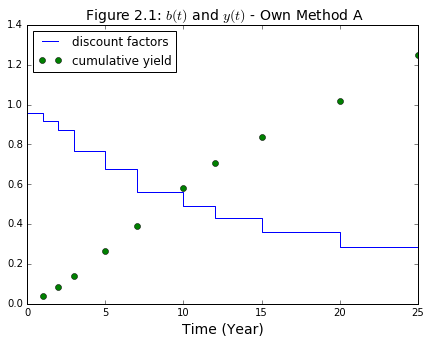

In [6]:
def swap2df(s,terms):
    '''Swap rates to piecewise flat discount factors'''
    d = np.zeros(len(terms))
    interval = np.diff(np.insert(terms,0,0))
    d[0] = 1./(s[0]+1)*interval[0]
    for i in range(1,len(terms),1):
        d[i] = (1-s[i]*sum(d*interval))/(1+interval[i]*s[i])
    return d

d=swap2df(par,terms)
m=dict(zip(terms,d))
m.update(dict(zip(terms[:-1] + 1e-6, d[1:])))
m[0] = d[0]
k, v = zip(*sorted(m.items()))
cy = -np.log(d)
plt.figure(figsize=[7,5])
plt.plot(k, v,'-')
plt.plot(terms,cy,'o')
plt.legend(['discount factors'] + ['cumulative yield'], loc='best')
plt.xlabel('Time (Year)', fontsize=14)
plt.title(' Figure 2.1: $b(t)$ and $y(t)$ - Own Method A', fontsize=14)
plt.show()

The cumulative yield curve is interpolated using tension splines. As can be seen in Figure 2.2 below, varying $\lambda$ does not change the shape of the curve significantly. The L-2 norm of the pricing errors $\Vert \epsilon \Vert _2$ using this method is roughly 0.067 when $\lambda = 0$. The breakdown of errors is printed below, followed by Figure 2.3 showing $\Vert \epsilon \Vert _2$ as a function of $\lambda$. It is found that the norm is not continuous at $\lambda \approx 1.33$. 

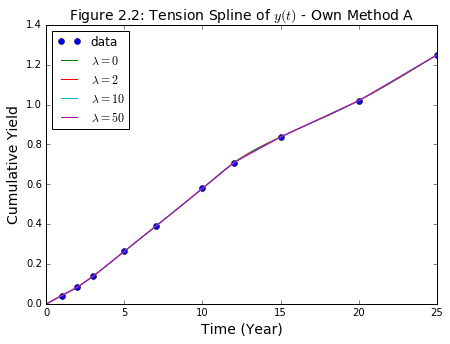

PV by maturity, lambda = 0:
1 Y : 0.0004198
2 Y : 0.0008792
3 Y : 0.001551
5 Y : 0.00588
7 Y : 0.009943
10 Y : 0.0191
12 Y : 0.02232
15 Y : 0.02549
20 Y : 0.03321
25 Y : 0.04204


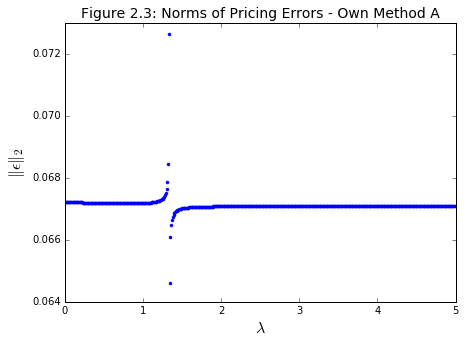

In [35]:
def plotTension(x, y, lbds, xd):
    plt.plot(x, y, 'o')

    for lbd in lbds:
        ts = tensionSpline(x, y, lbd, xd)
        plt.plot(xd, ts.value(xd))

    plt.legend(['data'] + ['$\lambda = %.f$' % l for l in lbds], loc='best')

def tensionSpline (x,y,lbd,xd):
    ts = lin.RationalTension(lbd)
    ts.build(x, y)
    return ts

# plot tension splines of y(t)
lbds = (0, 2, 10, 50)
xs = np.arange(0,25.1,.1)
plt.figure(figsize=[7,5])
plotTension(terms, cy, lbds, xs)
plt.ylabel('Cumulative Yield', fontsize=14)
plt.ylim([0, 1.4])
plt.xlabel('Time (Year)',fontsize=14)
plt.title('Figure 2.2: Tension Spline of $y(t)$ - Own Method A', fontsize=14)
plt.show()
  
# create the benchmark instruments and print out errors
bm_swaps = {Swap(m, c, 2) : 0 for m, c in zip (terms, par)}
ts = tensionSpline(terms,cy,lbds[0],xs)
pvs = {swap.maturity : y2pv(swap, ts) for swap in bm_swaps.keys()}
print "PV by maturity, lambda = 0:"
print "\n".join(["%.2g Y : %.4g" % (m, v) for m, v in pvs.items()])

# plot error vs. lambda
def plotError(benchmark, x, y, lbds, xd):
    error = np.zeros(len(lbds))
    for i, lbd in enumerate(lbds):
        ts = tensionSpline(x, y, lbd, xd)
        error[i] = np.linalg.norm([y2pv(swap, ts) for swap in benchmark.keys()],2)
            
    plt.plot(lbds,error,'.')
    plt.xlabel('$\lambda$', fontsize=16)
    plt.ylabel('$\Vert \epsilon \Vert _2$', fontsize=16)

lbds = np.arange(0, 5, 0.01)
plt.figure(figsize=[7,5])
plotError(bm_swaps, terms, cy, lbds, xs)
plt.title('Figure 2.3: Norms of Pricing Errors - Own Method A',fontsize=14)
plt.show()

(B) The second method also uses the market swap rates $s(t)$ to calculate $b(t)$, assuming that the forward rate between two consecutive tenors is flat. In essence, an implied discount factor is calculated for missing data points not availble from the swap market using information from the next available tenor. For example, the discount factor at $t=0.5$ year, $b(0.5)$, is calculated as $b(1)^{0.5/1}$; likewise, $b(1.5) = b(2)^{1.5/2}$, $b(3.5) = b(5)^{3.5/5}$, etc. Root finding using the Brent method is performed in this process. Figure 2.4 below shows the discount factors and cumulative yield calculated using this method. 

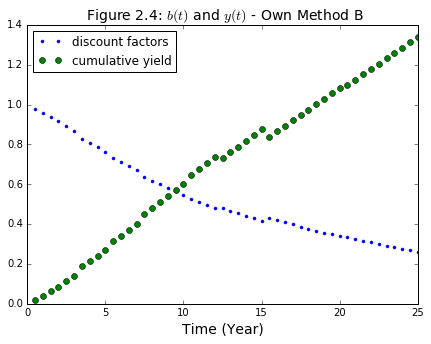

In [24]:
def swap2df2(par,terms,freq):
    '''Swap rates to discount factors with flat rate of return in between tenor intervals'''
    k = np.arange(1./freq, terms[-1] + 1e-6, 1./freq) # payment dates
    d = dict(zip(k,np.zeros(len(k)))) # discount factors
    s = dict(zip(terms,par))
    
    for i in range(len(terms)):
        t = terms[i]
        if i == 0:
            d[t] = opt.brentq(pv_c, 0, 1, args=(s[t], t, d, freq, 0))
            for j in np.arange(1./freq, t, 1./freq):
                d[j] = (d[t])**(j/t)
        if i > 0:
            d[t] = opt.brentq(pv_c, 0, 1, args=(s[t], t, d, freq, terms[i-1]))
            for j in np.arange(1./freq+terms[i-1], t, 1./freq):
                d[j] = (d[t])**(j/t)

    return np.array([d[x] for x in k])

def pv_c(x,s,t,d,freq,prev_term):
    if prev_term == 0:
        tmp = 0
    else:
        tmp = np.sum([d[m]/freq for m in np.arange(1./freq, prev_term+1e-6,1./freq)])
    for j in np.arange(1./freq+prev_term, t+1e-6, 1./freq):
        tmp = tmp + 1./freq*x**(j/t)
    return tmp*s+x-1

dd = swap2df2(par, terms, 2) # discount factors - Method B
k = np.arange(1./2, terms[-1] + 1e-6, 1./2)
cyy = -np.log(dd) # cumulative yield y(t)
plt.figure(figsize=[7,5])
plt.plot(k, dd,'.')
plt.plot(k, cyy,'o')
plt.legend(['discount factors'] + ['cumulative yield'], loc='best')
plt.xlabel('Time (Year)', fontsize=14)
plt.title(' Figure 2.4: $b(t)$ and $y(t)$ - Own Method B', fontsize=14)
plt.show()

As can be seen above, there are some jumps in the two curves, which become more obvious in the implied forward rate curve shown in Figure 2.5 below. Explicitly, the 6-month forward rate implied by $b(t)$ is calculated as

$$ f(i)=\frac {b(i-1)/b(i)-1}{\delta_i}, \; i=2,3,...50 $$

where $ \delta_i = 0.5 \; \forall i$ in this case.

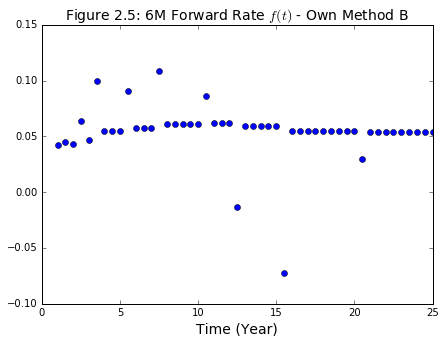

In [30]:
F = (np.divide(dd[:-1],dd[1:])-1)/0.5
plt.figure(figsize=[7,5])
plt.plot(k[1:],F,'o')
plt.title("Figure 2.5: 6M Forward Rate $f(t)$ - Own Method B", fontsize=14)
plt.xlabel("Time (Year)", fontsize=14)
plt.show()

As with the first method, the cumulative yield curve is then interpolated using tension splines. However, $\Vert \epsilon \Vert _2$ using this method is only ```+7.26e-13``` when $\lambda = 0$, which is significantly smaller than the result from Method A (and smaller than the error from the built-in algorithm, to be shown later as Method C). The breakdown of errors is printed below, followed by Figure 2.7 showing $\Vert \epsilon \Vert _2$ as a function of $\lambda$. It is found that the norm starts to diverge as $\lambda$ increases. 

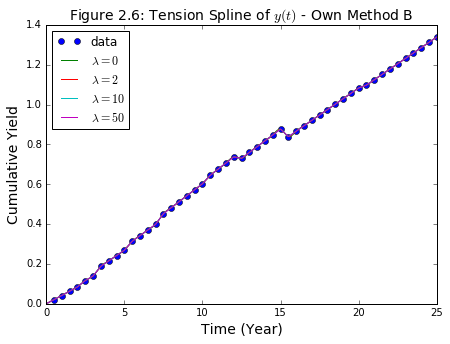

PV by maturity, lambda = 0:
1 Y : 4.175e-13
2 Y : 1.65e-13
3 Y : 1.685e-13
5 Y : 3.032e-17
7 Y : -4.004e-17
10 Y : 6.072e-15
12 Y : 2.965e-16
15 Y : 7.688e-15
20 Y : 0
25 Y : 5.45e-13


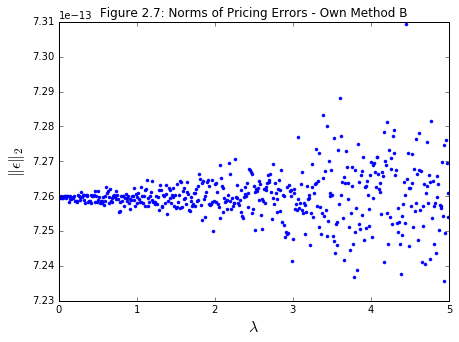

In [38]:
# plot tension splines of y(t)
lbds = (0, 2, 10, 50)
xs = np.arange(0,25.1,.1)
plt.figure(figsize=[7,5])
plotTension(k, cyy, lbds, xs)
plt.ylabel('Cumulative Yield', fontsize=14)
plt.ylim([0, 1.4])
plt.xlabel('Time (Year)',fontsize=14)
plt.title('Figure 2.6: Tension Spline of $y(t)$ - Own Method B', fontsize=14)
plt.show()
  
# pricing errors
ts = tensionSpline(k,cyy,lbds[0],xs)
pvs = {swap.maturity : y2pv(swap, ts) for swap in bm_swaps.keys()}
print "PV by maturity, lambda = 0:"
print "\n".join(["%.2g Y : %.4g" % (m, v) for m, v in pvs.items()])

# plot error vs. lambda
lbds = np.arange(0, 5, 0.01)
plt.figure(figsize=[7,5])
plotError(bm_swaps, k, cyy, lbds, xs)
plt.title('Figure 2.7: Norms of Pricing Errors - Own Method B',fontsize=12)
plt.show()

(C) The last method for this question uses the built-in bootstrap algorithms from the ```inst``` package. In Figure 2.8 below, the cumulative yield curve is interpolated with a piecewise-linear property, which is equivalent to a piecewise-flat interpolation of its derivative $f(t)$, the instantaneous forward rate.

In Figure 2.9, different tension splines are obtained by varying $\lambda$. As in the previous method, $\lambda$ is found to have very limited impact on the shape of interpolated $y(t)$. Also, they look similar in shape to the results obtained using the first method. 

However, $\Vert \epsilon \Vert _2$ in this case is roughly ```+6.5e-4``` when $\lambda = 0$, which is considerably smaller than the value obtained using the first method. The breakdown of errors is printed below, followed by Figure 2.10 showing $\Vert \epsilon \Vert _2$ as a function of $\lambda$. Again, the norm is not continuous at $\lambda \approx 1.33$, but is in a decreasing trend away from the discontinuity.

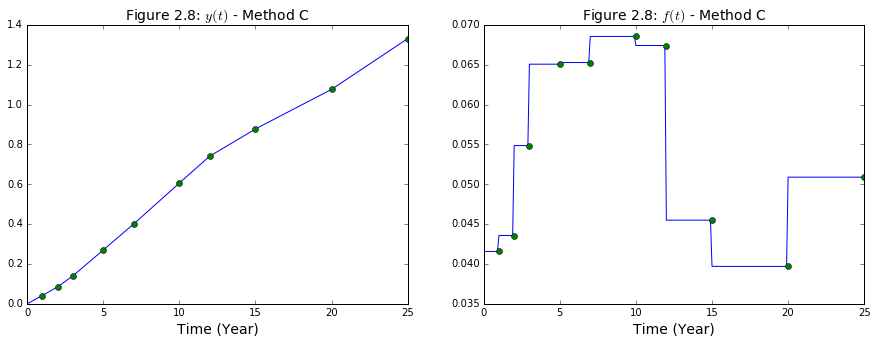

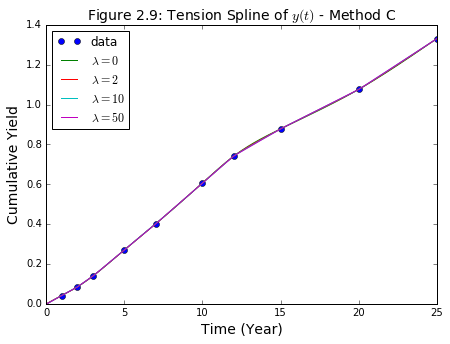

PV by maturity, lambda=0
1 Y : 1.57e-06
2 Y : 2.027e-05
3 Y : 5.284e-05
5 Y : 0.0001447
7 Y : 0.000147
10 Y : 0.00029
12 Y : 0.0001803
15 Y : -0.0002276
20 Y : 8.002e-05
25 Y : 0.0003891


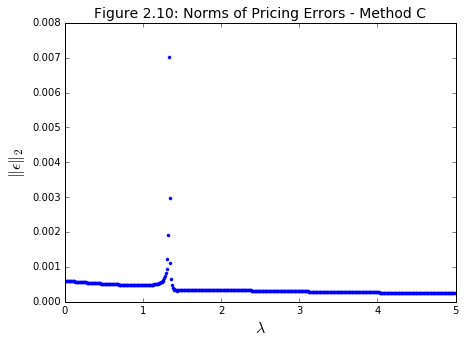

In [37]:
# piecewise-linear interpolation of y(t)
hlin = lin.PiecewiseLinear()
hlin.build(terms, terms*.01)
hlin.addKnot(0, 0)
hlin = inst.bootstrap(bm_swaps, hlin, y2pv, bds = [-2., 2.])

plt.figure(figsize=[15, 5])
plt.subplot(1, 2, 1)
plt.plot(xs, hlin(xs))
plt.plot(terms, hlin(terms), 'o')
plt.xlabel('Time (Year)', fontsize=14)
plt.title('Figure 2.8: $y(t)$ - Method C', fontsize=14);

plt.subplot(1, 2, 2)
plt.plot(xs, hlin.deriv(xs))
plt.plot(terms, hlin.deriv(terms-1e-4), 'o')
plt.xlabel('Time (Year)', fontsize=14)
plt.title('Figure 2.8: $f(t)$ - Method C', fontsize=14);

# tension spline interpolations of y(t)
lbds = (0, 2, 10, 50)
xs = np.arange(0,25.1,.1)
plt.figure(figsize=[7,5])
plotTension(terms, hlin(terms), lbds, xs)
plt.ylabel('Cumulative Yield', fontsize=14)
plt.ylim([0,1.4])
plt.xlabel('Time (Year)', fontsize=14)
plt.title('Figure 2.9: Tension Spline of $y(t)$ - Method C', fontsize=14)
plt.show()

# error and norms
ts = tensionSpline(terms,hlin(terms),0,xs)
pvs = {swap.maturity : y2pv(swap,ts) for swap in bm_swaps.keys()}
print "PV by maturity, lambda=0"
print "\n".join(["%.2g Y : %.4g" % (m, v) for m, v in pvs.items()])

lbds = np.arange(0, 5, 0.01)
plt.figure(figsize=[7,5])
plotError(bm_swaps, terms, hlin(terms), lbds, xs)
plt.title('Figure 2.10: Norms of Pricing Errors - Method C', fontsize=14)
plt.show()

**3)** Using the built-in ```inst.iterboot()``` method, $\Vert \epsilon \Vert _2$ can be reduced to below 1bp with only 2 iterations when $\lambda = 0$, as shown in Figure 3 below.

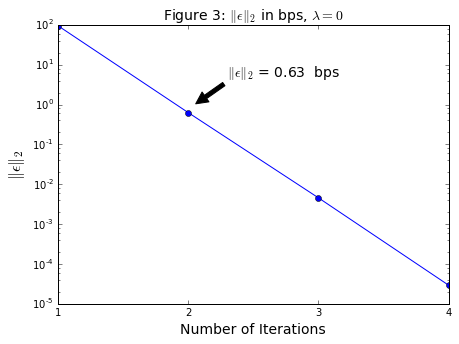

In [9]:
_, e = inst.iterboot(bm_swaps, y2pv, lbd=0, x0=0, its=4 , bds=[-1., 3.])

err = [np.linalg.norm(e[i,:],2)*1e4 for i in range(4)]
plt.figure(figsize=[7,5])
x = range(1,5,1)
plt.plot(x, err,'-o')
plt.xticks(x, [1,2,3,4])
plt.xlabel('Number of Iterations', fontsize=14)
plt.ylabel('$\Vert \epsilon \Vert _2$', fontsize=16)
plt.yscale('log')
plt.title('Figure 3: $\Vert \epsilon \Vert _2$ in bps, $\lambda = 0$', fontsize=14)
plt.annotate('$\Vert \epsilon \Vert _2  $ = 0.63  bps', xy=(2.05, 1), xytext=(2.3, 5),
            arrowprops=dict(facecolor='black', shrink=0.03), fontsize = 14)
plt.show()

**4)** The term structures of cumulative yield $y(t)$ and instantaneous forward rate $f(t)$ are plotted below in Figure 4.1 with different values of the tension parameter $\lambda$. To facilitate visual comparisons, $y(t)$ and $f(t)$ curves when $\lambda$ is different are plotted on top of each other, respectively, in Figure 4.2. Once again, $\lambda$ has no visible impacts on $y(t)$; nevertheless, the shape of $f(t)$ changes dramatically from very smooth to piecewise-linear as $\lambda$ increases. 

Figure 4.1: y(t) and f(t) with different lambda


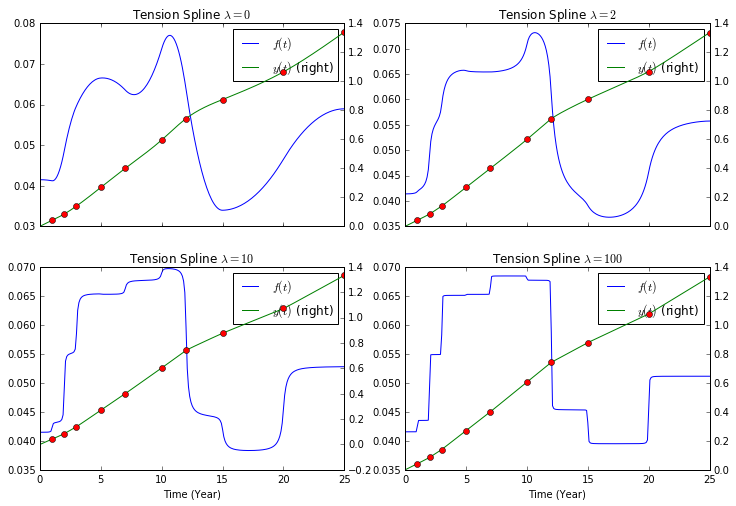

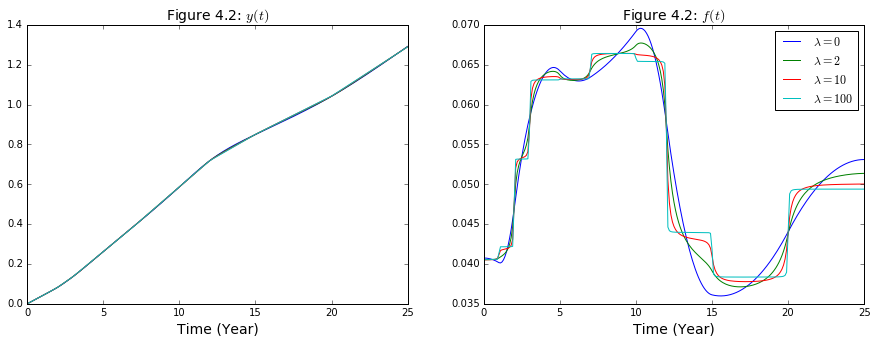

In [10]:
# Figure 4.1
def plotboot(tsit, lbd, ax, tagsf) :
    plt.xlabel('Time (Year)')    
    
    lbd_tag = '$\\lambda=%.f$' % lbd
    df = pd.DataFrame({'Time (Year)':xs}).set_index(['Time (Year)'])
    
    for tag, f in tagsf.items() :
        df[tag] = f(tsit, xs) 
    
    df.plot(ax = ax, secondary_y = [tagsf.keys()[1]], title = 'Tension Spline ' + lbd_tag)
    plt.plot(terms, tsit(terms), 'o')

tagsf = {"$y(t)$" : lambda cv, xs : cv(xs), "$f(t)$": lambda cv, xs : cv.deriv(xs)}

lbds = [0, 2, 10, 100]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[12, 8])

print("Figure 4.1: y(t) and f(t) with different lambda")
for lbd, ax in zip(lbds, axes.flatten()) :
    tsit, e = inst.iterboot(bm_swaps, y2pv, lbd=lbd, x0=0, its=1 , bds=[-1., 3.])
    plotboot(tsit, lbd, ax, tagsf)
    
# Figure 4.2
def pv_lbds(bms, y2pv, lbds, x0) :
    cvs = []
    for lbd in lbds:
        cv, e = inst.iterboot(bms, y2pv, x0, lbd, mixf = 0.5, bds=[-3.,3.])
        cvs.append(cv)
    
    return cvs

tags = ['$\\lambda=%.f$' % l for l in lbds]
cv0 = pv_lbds(bm_swaps, y2pv, lbds, 0)

plt.figure(figsize=[15, 5])
plt.subplot(1, 2, 1)
plt.plot(xs, np.array([cv(xs) for cv in cv0]).T);
plt.ylim([0,1.4])
plt.title('Figure 4.2: $y(t)$', fontsize=14)
plt.xlabel('Time (Year)', fontsize=14)

plt.subplot(1, 2, 2)
plt.plot(xs, np.array([cv.deriv(xs) for cv in cv0]).T);
plt.legend(tags, loc='best');
plt.title('Figure 4.2: $f(t)$', fontsize=14)
plt.xlabel('Time (Year)', fontsize=14)
plt.show()

When there is a 1bp perturbation on the 5Y swap rate, the instantaneous forward rate curve also changes around the 5Y tenor. As shown in Figure 4.3, the change may get as large as 4bps when $\lambda = 0$. In general, the larger the $\lambda$, the more local the change in $f(t)$ is, which is a highly desirable property.  

Figure 4.3


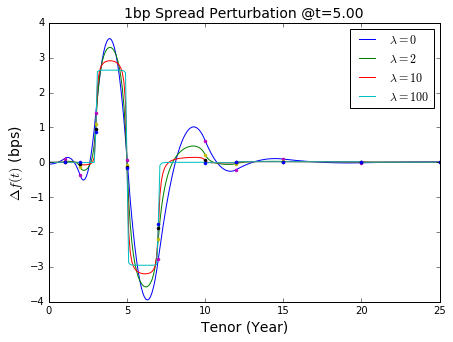

In [11]:
def showPerts(bms, bms_ps, y2pv, lbds, x0, pertf) :
    cv0 = pv_lbds(bms, y2pv, lbds, x0=x0)
    cvp = pv_lbds(bms_ps, y2pv, lbds, x0=x0)
    
    lbd_tags = ['$\\lambda=%.f$' % lbd for lbd in lbds]

    plt.figure(figsize=[7, 5])
    plt.plot(xs, 1e4*np.array([pertf(f, g)(xs) for f, g in zip(cv0, cvp)]).T);
    plt.xlabel('Tenor (Year)', fontsize=14)
    plt.ylabel('$\Delta f(t)$ (bps)', fontsize = 14)
    plt.title('1bp Spread Perturbation @t=%.2f' % pt, fontsize = 14)
    plt.legend(lbd_tags, loc='best');
    plt.plot(terms, 1e4*np.array([pertf(f, g)(terms) for f, g in zip(cv0, cvp)]).T, '.');
    
    
pt = 5
bms_ps = {k if k.maturity != pt else Swap(k.maturity, k.coupon-1e-4, k.freq) : v 
        for k, v in bm_swaps.items()}

print("Figure 4.3")
showPerts(bm_swaps, bms_ps, y2pv, lbds, 0, lambda f, g : lambda xs : f.deriv(xs) - g.deriv(xs))

**5)** Directly interpolating the instantaneous forward curve $f(t)$ is not recommended. As shown in Figure 5.1 below, as $\lambda$ gets bigger, the interpolation becomes piecewise linear and leads to zig-zags. The resulting cumulative yield also behaves like waves.

Figure 5.1: Interpolating f(t)


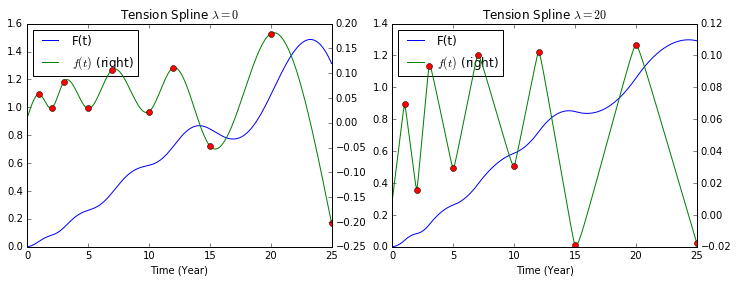

In [12]:
# forward rate curve to swap price
def f2pv(swap, curve):
    discf = lambda ts: np.exp(-curve.integral(ts))
    return priceSwap(swap, discf)

x0 = .01
chartf = {'F(t)' : lambda cv, xs : cv.integral(xs), '$f(t)$' : lambda cv, xs : cv(xs), }

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[12, 4])

lbds = (0, 20)
tsit0, e0 = inst.iterboot(bm_swaps, f2pv, x0, lbds[0], mixf=.5, bds=[-3.,3.])
plotboot(tsit0, lbds[0], axes[0], chartf)    

tsit1, e1 = inst.iterboot(bm_swaps, f2pv, x0, lbds[1], mixf=.5, bds=[-3.,3.])
plotboot(tsit1, lbds[1], axes[1], chartf) 
print("Figure 5.1: Interpolating f(t)")
plt.show()

In this case, perturbation in a single tenor generates waves throughout the forward rate term structure, as illustrated by Figure 5.2 below.

Figure 5.2


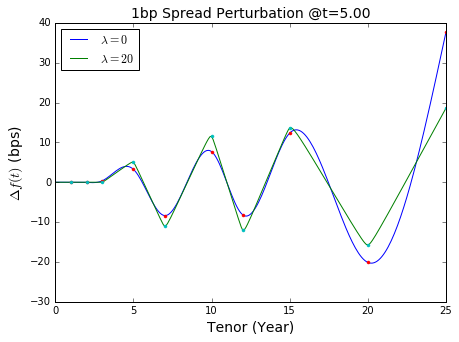

In [13]:
print("Figure 5.2")
showPerts(bm_swaps, bms_ps, f2pv, lbds, x0, lambda f, g : lambda xs : f(xs) - g(xs))